In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
df_full_obs = pd.read_csv('.obs.tsv.tmp', sep='\t')
df_full_sug = pd.read_csv('.sug.tsv.tmp', sep='\t')

In [3]:
print(df_full_obs.shape)
print(df_full_sug.shape)

(70, 19)
(70, 23)


In [4]:
min_threshold = 25

obs_cols_to_keep = [
    x[0]
    for x in df_full_obs.astype('bool').sum().iteritems()
    if x[1] >= min_threshold
]

sug_cols_to_keep = [
    x[0]
    for x in df_full_sug.astype('bool').sum().iteritems()
    if x[1] >= min_threshold
]

df_smaller_obs = df_full_obs[obs_cols_to_keep]
df_smaller_sug = df_full_sug[sug_cols_to_keep]

In [5]:
print(df_smaller_obs.shape)
print(df_smaller_sug.shape)

(70, 10)
(70, 11)


In [6]:
sys.path.append('util/')
from util import *

In [144]:
max_categories = 2

valid_obs_cols_to_try = filter_for_length(get_powerset(df_smaller_obs.columns), length=2)
valid_sug_cols_to_try = filter_for_length(get_powerset(df_smaller_sug.columns), length=2)

valid_obs_cols_to_try = [x for x in valid_obs_cols_to_try if len(x) <= max_categories]
valid_sug_cols_to_try = [x for x in valid_sug_cols_to_try if len(x) <= max_categories]

In [146]:
print(len(valid_obs_cols_to_try))
print(len(valid_sug_cols_to_try))

45
55


In [139]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
folds = 3

In [140]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=Warning)

In [150]:
to_try = 1
tried = 0

results = []

try:
    for obs_subset in valid_obs_cols_to_try[::-1]:
        for sug_subset in valid_sug_cols_to_try[::-1]:
#             if tried >= to_try:
#                 raise StopIteration
            if tried % 25 == 0:
                print(tried, end='  ')

            selected_obs = df_smaller_obs[obs_subset]
#             selected_sug = df_smaller_sug[sug_subset]
            
            all_scores = []
            for sug_label in sug_subset:
                single_label_cv_score = cross_val_score(
                    rf, selected_obs, df_smaller_sug[[sug_label]], cv=folds
                )
                all_scores.append(single_label_cv_score.mean())
            
            macro_averaged_subset_score = sum(all_scores) / len(all_scores)
            
#             print(macro_averaged_subset_score)
#             scores = cross_val_score(rf, selected_obs, selected_sug, cv=folds)
        
            results.append(tuple([
                macro_averaged_subset_score,
                obs_subset,
                sug_subset
            ]))
            
            tried += 1
            
except StopIteration:
    pass

sorted_results = sorted(results, key=lambda x: x[0])

0  25  50  75  100  125  150  175  200  225  250  275  300  325  350  375  400  425  450  475  500  525  550  575  600  625  650  675  700  725  750  775  800  825  850  875  900  925  950  975  1000  1025  1050  1075  1100  1125  1150  1175  1200  1225  1250  1275  1300  1325  1350  1375  1400  1425  1450  1475  1500  1525  1550  1575  1600  1625  1650  1675  1700  1725  1750  1775  1800  1825  1850  1875  1900  1925  1950  1975  2000  2025  2050  2075  2100  2125  2150  2175  2200  2225  2250  2275  2300  2325  2350  2375  2400  2425  2450  

In [151]:
len(results)

2475

In [158]:
for x, y, z in sorted_results[::-1][:10]:
    print('{:.1f}%\n\tOBS$: {}\n\tSUG$: {}'.format(x * 100, '\t'.join(y), '\t'.join(z)))

63.2%
	OBS$: PHONICS	RATE
	SUG$: PHONICS	WORD_ENDINGS
61.6%
	OBS$: MONITORING_FOR_MEANING	PHONICS
	SUG$: PHONICS	SELF_MONITOR
61.5%
	OBS$: ACCURACY	SIGHT_WORDS
	SUG$: PHONICS	WORD_ENDINGS
60.5%
	OBS$: MONITORING_FOR_MEANING	SIGHT_WORDS
	SUG$: PHONICS	SIGHT_WORD
60.0%
	OBS$: MONITORING_FOR_MEANING	SIGHT_WORDS
	SUG$: PHONICS	PUNCTUATION
59.7%
	OBS$: ACCURACY	SELF_CORRECTION
	SUG$: SIGHT_WORD	WORD_ENDINGS
59.4%
	OBS$: ACCURACY	SIGHT_WORDS
	SUG$: PHONICS	SIGHT_WORD
59.2%
	OBS$: PHONICS	PHRASING
	SUG$: EXPRESSION	PHONICS
58.8%
	OBS$: MONITORING_FOR_MEANING	PUNCTUATION
	SUG$: PHONICS	WORD_ENDINGS
58.6%
	OBS$: ACCURACY	FLUENCY
	SUG$: PHONICS	SELF_MONITOR


different approach, heatmap

heatmap among observations

In [16]:
import seaborn as sns
import matplotlib.pylab as plt

In [17]:
test_a = pd.Series([1, 0, 1])
test_

In [24]:
df_obs_ternary = df_full_obs.copy()
m, n = df_obs_ternary.shape
for ri in range(m):
    for ci in range(n):
        if df_obs_ternary.iat[ri, ci] > 0:
            df_obs_ternary.iat[ri, ci] = 1
        if df_obs_ternary.iat[ri, ci] < 0:
            df_obs_ternary.iat[ri, ci] = -1

In [31]:
def match_sim(l1, l2):
    assert len(l1) == len(l2)
    return len([x for idx, x in enumerate(l1) if l2[idx] == x]) / len(l1)

pair_sims = set()

for column in df_obs_ternary:
    for other_column in df_obs_ternary:
        sim = match_sim(list(df_obs_ternary[column]), list(df_obs_ternary[other_column]))
        pair_sims.add(tuple([sim, column, other_column]))
        

In [39]:
len(pair_sims) ** .5 == n

True

In [43]:
from collections import defaultdict
sims_dict = defaultdict(dict)

for pair_sim in pair_sims:
    sim, cat1, cat2 = pair_sim
    sims_dict[cat1][cat2] = sim

In [62]:
obs_corr_mat = []
for idx in range(len(df_obs_ternary.columns)):
    orig = list(df_obs_ternary.columns)[idx]
    to_append = [sims_dict[orig][col_title] for col_title in df_obs_ternary.columns]
    
    obs_corr_mat.append(to_append)

In [70]:
obs_corr_df = pd.DataFrame(obs_corr_mat)
obs_corr_df.columns = df_obs_ternary.columns
obs_corr_df_row_names = {
    idx: name
    for idx, name in enumerate(list(df_obs_ternary))
}
obs_corr_df.rename(index=obs_corr_df_row_names, inplace=True)

In [159]:
def heat(df, title=''):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    sns.heatmap(df, cmap='Blues', square=True)
    plt.show()

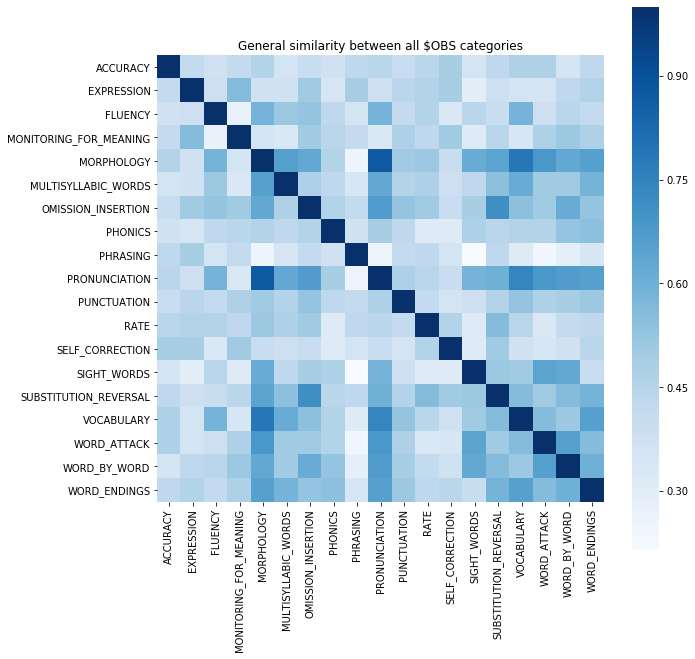

In [160]:
heat(obs_corr_df, title='General similarity between all $OBS categories')

removing sparse columns

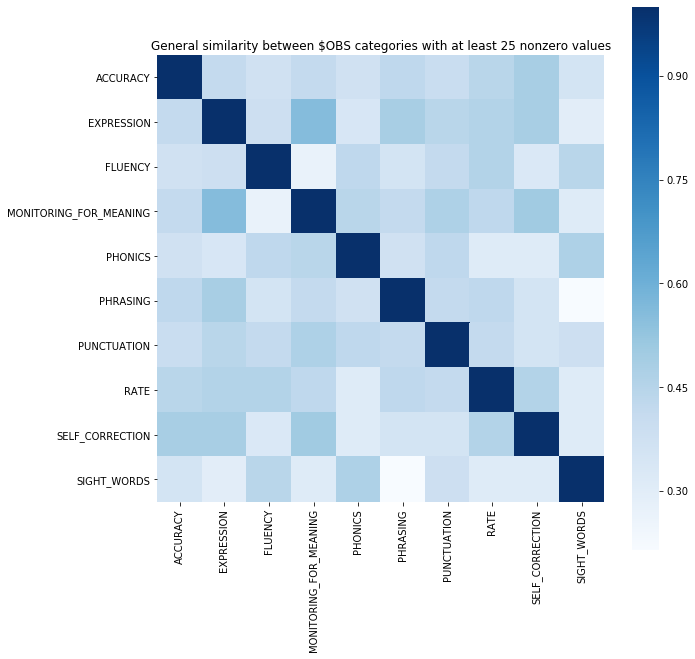

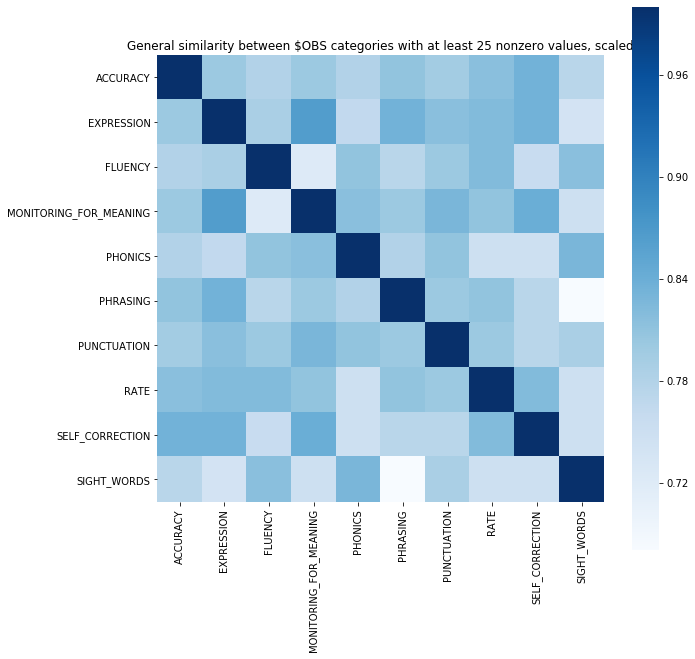

In [161]:
minimum = 25
to_drop = [
    x
    for x, y in dict(df_obs_ternary.astype('bool').sum()).items()
    if y < minimum
]
smaller_obs_corr_df = obs_corr_df.drop(to_drop).drop(to_drop, axis=1)
heat(
    smaller_obs_corr_df,
    title='General similarity between $OBS categories with at least {} nonzero values'.format(minimum)
)
scaled_smaller_obs_corr_df = smaller_obs_corr_df.copy()
for col in scaled_smaller_obs_corr_df:
    scaled_smaller_obs_corr_df[col] = (scaled_smaller_obs_corr_df[col]) ** .25
heat(
    scaled_smaller_obs_corr_df,
    title='General similarity between $OBS categories with at least {} nonzero values, scaled'.format(minimum)
)

In [162]:
df_sug_ternary = df_full_sug.copy()
m, n = df_sug_ternary.shape
for ri in range(m):
    for ci in range(n):
        if df_sug_ternary.iat[ri, ci] > 0:
            df_sug_ternary.iat[ri, ci] = 1
        if df_sug_ternary.iat[ri, ci] < 0:
            df_sug_ternary.iat[ri, ci] = -1

In [163]:
pair_sims = set()
for column in df_sug_ternary:
    for other_column in df_sug_ternary:
        sim = match_sim(list(df_sug_ternary[column]), list(df_sug_ternary[other_column]))
        pair_sims.add(tuple([sim, column, other_column]))

In [164]:
sims_dict = defaultdict(dict)
for pair_sim in pair_sims:
    sim, cat1, cat2 = pair_sim
    sims_dict[cat1][cat2] = sim

In [165]:
sug_corr_mat = []
for idx in range(len(df_sug_ternary.columns)):
    orig = list(df_sug_ternary.columns)[idx]
    to_append = [sims_dict[orig][col_title] for col_title in df_sug_ternary.columns]
    
    sug_corr_mat.append(to_append)

In [166]:
sug_corr_df = pd.DataFrame(sug_corr_mat)
sug_corr_df_row_names = {
    idx: name
    for idx, name in enumerate(list(df_sug_ternary))
}
sug_corr_df.rename(index=sug_corr_df_row_names, inplace=True)
sug_corr_df.columns = df_sug_ternary.columns

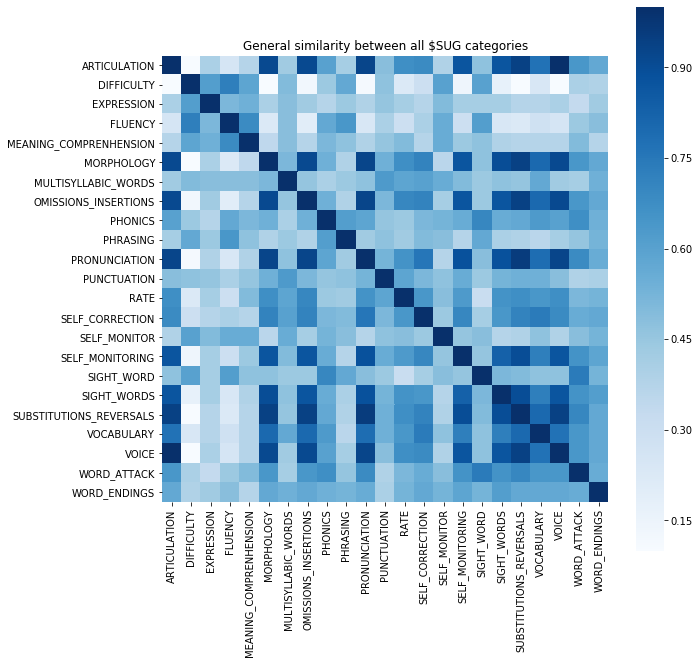

In [167]:
heat(sug_corr_df, title='General similarity between all $SUG categories')

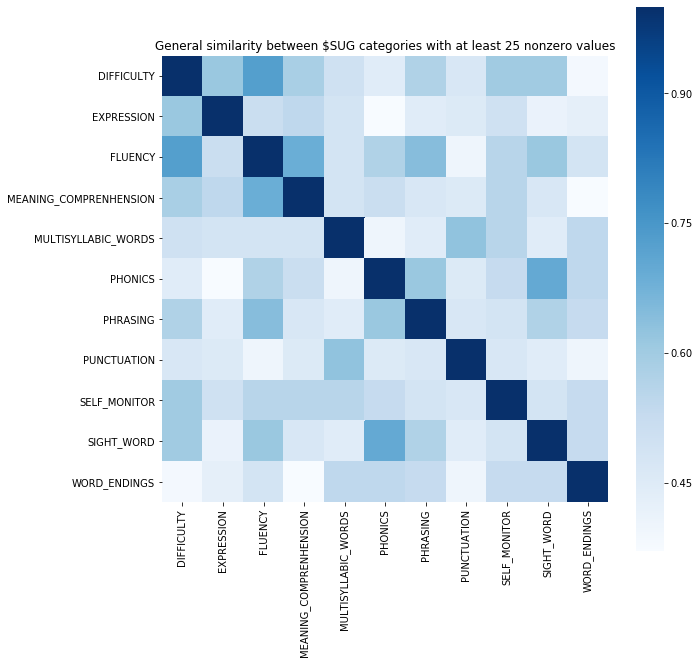

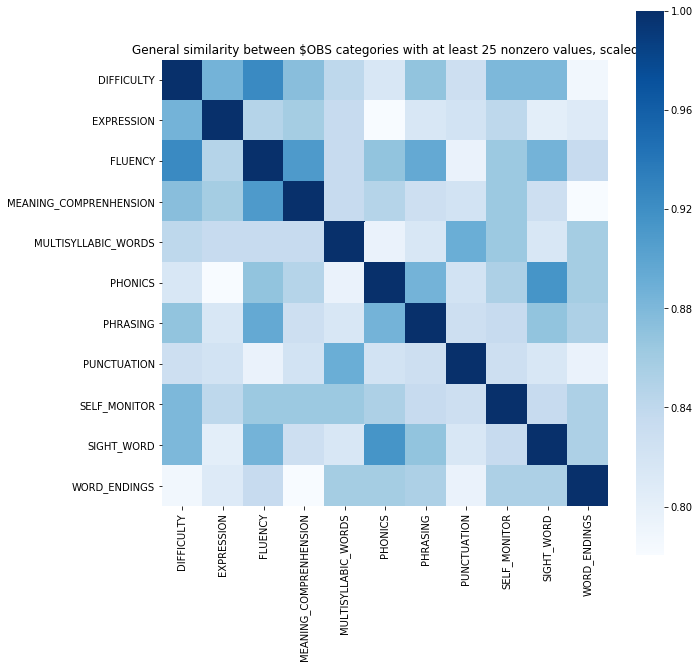

In [168]:
minimum = 25
to_drop = [
    x
    for x, y in dict(df_sug_ternary.astype('bool').sum()).items()
    if y < minimum
]
smaller_sug_corr_df = sug_corr_df.drop(to_drop).drop(to_drop, axis=1)
heat(
    smaller_sug_corr_df,
    title='General similarity between $SUG categories with at least {} nonzero values'.format(minimum)
)
heat(
    smaller_sug_corr_df ** .25,
    title='General similarity between $OBS categories with at least {} nonzero values, scaled'.format(minimum)
)